# Unsupervised denoising for experimental data

This notebook gives a general introduction on denoising machine learning, followed by an explanation of the DnCNN and Unet architectures which are the models we will use.

Adapted from: https://github.com/czbiohub-sf/noise2self/blob/master

Contents:
* [Loading some data](#load)
* [Noise2Self: masking the data](#masking)
* [Popular models for denoising tasks](#model)
* [Training the model!](#training)


In [ ]:
# First some imports
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import Dataset
from torch import randn
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.nn import MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader

In [ ]:
# Some useful functions
def show_tensor(tensor, cmap='magma', scale=False):
    im = tensor.numpy()
    if scale:
        im = im / im.max()
    else:
        im = clip(im, 0, 1)

    if im.shape[0] == 1:
        plt.imshow(im[0], cmap=cmap)
    else:
        plt.imshow(im.transpose((1, 2, 0)))


def tensor_to_numpy(x):
    x = x.detach().cpu().numpy()
    if x.ndim == 4:
        x = x[0]
    if x.ndim == 2:
        return x

    if x.shape[0] == 1:
        return x[0]
    elif x.shape[0] == 3:
        return x.transpose((1, 2, 0))
    else:
        raise


def plot_tensors(tensor_list, titles=None):
    color = True if tensor_list[0].shape[1] == 3 else False
    image_list = [tensor_to_numpy(tensor) for tensor in tensor_list]
    width = len(image_list)
    fig, ax = plt.subplots(1, width, sharex='col', sharey='row', figsize=(width * 4, 4))

    for i in range(width):
        if image_list[i].ndim == 2:
            ax[i].imshow(image_list[i], cmap='Greys_r')
        else:
            ax[i].imshow(image_list[i])
        if titles:
            ax[i].set_title(titles[i])
        ax[i].get_xaxis().set_ticks([])
        ax[i].get_yaxis().set_ticks([])
    fig

## Loading some data <a class="anchor" id="load"></a>
Training a neural network with pairs of input and target images is called supervised learning. In supervised learning for denoising neural networks, a dataset contains pairs of noisy input and clean target images. The clean target images are also called the ground truth of the data. If the network is then trained on the training data, it can be used to denoise new unseen data. However, since we are dealing with experimental data, the ground truth of the images is often unknown. To solve this problem, this notebook introduces so-called self-supervised learning techniques to create pairs of training images from only the noisy experimental data.

Here we load some MNIST (handwritten digits) images, but you could replace this data with experimental images.

In [ ]:
# Download the images
mnist_train = MNIST('/data/MNIST', download = True,
                    transform = transforms.Compose([
                        transforms.ToTensor(),
                    ]), train = True)

mnist_test = MNIST('/data/MNIST', download = True,
                    transform = transforms.Compose([
                        transforms.ToTensor(),
                    ]), train = False)

In [ ]:
# Functions to add some noise to the images
def add_noise(img):
    return img + randn(img.size())*0.4

class SyntheticNoiseDataset(Dataset):
    def __init__(self, data, mode='train'):
        self.mode = mode
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = self.data[index][0]
        return add_noise(img), img

# Add the noise
noisy_mnist_train = SyntheticNoiseDataset(mnist_train, 'train')
noisy_mnist_test = SyntheticNoiseDataset(mnist_test, 'test')

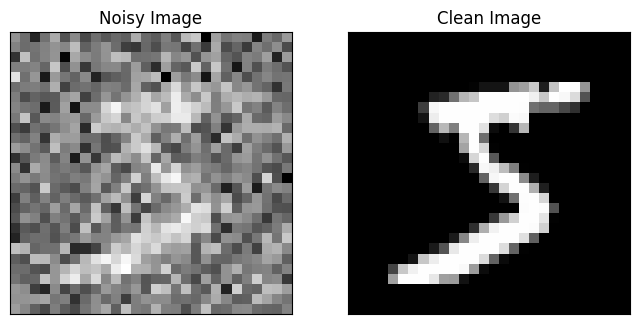

In [ ]:
# Show some examples
noisy, clean = noisy_mnist_train[0]
plot_tensors([noisy[0], clean[0]], ['Noisy Image', 'Clean Image'])

## Noise2Self: masking the data <a class="anchor" id="masking"></a>

In this notebook, the Noise2Self (N2S) method is used to denoise data in a self-supervised manner. For more reading and theoretical derivations, please see the original paper and its supplementary material (Batson et al, 2019).

Unless a measurement is purely noise, there is always at least some structure in the data. If the dimension of the structure in the data is much lower than the dimension of the measurement, this structure can be learned and used to remove noise from the data. The N2S method works by assuming pixel-independent noise and using the correlations in the data. For a true signal $y$ and its noisy measurement $x$, the theory works for functions $f$ such that a prediction $f(x)_J$ does not depend on $x_J$. The N2S authors call this class of functions ``J-invariant''. In the case of an image, this means the prediction for a pixel should not depend on the value of that pixel. For these functions, the optimal denoiser can be found by minimizing the self-supervised loss:

\begin{equation}
    L(f) = \mathbb{E} \lVert f(x)-x \rVert ^2
\end{equation}

where $\mathbb{E}$ indicates the expectation value. For pixel-independent noise, this equation can be rewritten to:

\begin{equation}
    \mathbb{E} \lVert f(x)-x \rVert ^2 = \mathbb{E} \lVert f(x)-y \rVert ^2
                                       + \mathbb{E} \lVert x-y \rVert ^2
\end{equation}

This equation shows that the self-supervised loss is the sum of the ordinary supervised loss $\mathbb{E} \lVert f(x)-y \rVert ^2$ and the variance of the noise $\mathbb{E} \lVert x-y \rVert ^2$. By minimizing the self-supervised loss, we can thus find the optimal denoiser for a noisy measurement.

For the N2S method to work, it is important to have a denoiser $f$ which is J-invariant. However, for most denoisers this is not naturally the case. Some methods can be easily adjusted, e.g. using a smearing filter with the center pixel cut out. For other methods, there is a more general way to adjust the method, using a **masking technique**. For the masking technique, the pixels of the image are divided into a number of subgroups. Each subgroup is then predicted individually by replacing the pixels of that group with averages of neighbours or random values. For example, if an image is divided into 25 subgroups, then the image is fed to the denoiser 25 times, each time with one of the subgroups masked, and each time only saving the outputs for that subgroup. This ensures that a certain pixel is predicted without using the original noisy value for that pixel, while still having access to the structure in the image.

In [ ]:
class Masker():
    """Object for masking and demasking"""

    def __init__(self, width=3, mode='zero', infer_single_pass=False, include_mask_as_input=False):
        self.grid_size = width
        self.n_masks = width ** 2

        self.mode = mode
        self.infer_single_pass = infer_single_pass
        self.include_mask_as_input = include_mask_as_input

    def mask(self, X, i):

        phasex = i % self.grid_size
        phasey = (i // self.grid_size) % self.grid_size
        mask = pixel_grid_mask(X[0, 0].shape, self.grid_size, phasex, phasey)
        mask = mask.to(X.device)

        mask_inv = torch.ones(mask.shape).to(X.device) - mask

        if self.mode == 'interpolate':
            masked = interpolate_mask(X, mask, mask_inv)
        elif self.mode == 'zero':
            masked = X * mask_inv
        else:
            raise NotImplementedError

        if self.include_mask_as_input:
            net_input = torch.cat((masked, mask.repeat(X.shape[0], 1, 1, 1)), dim=1)
        else:
            net_input = masked

        return net_input, mask

    def __len__(self):
        return self.n_masks

    def infer_full_image(self, X, model):

        if self.infer_single_pass:
            if self.include_mask_as_input:
                net_input = torch.cat((X, torch.zeros(X[:, 0:1].shape).to(X.device)), dim=1)
            else:
                net_input = X
            net_output = model(net_input)
            return net_output

        else:
            net_input, mask = self.mask(X, 0)
            net_output = model(net_input)

            acc_tensor = torch.zeros(net_output.shape).cpu()

            for i in range(self.n_masks):
                net_input, mask = self.mask(X, i)
                net_output = model(net_input)
                acc_tensor = acc_tensor + (net_output * mask).cpu()

            return acc_tensor

def pixel_grid_mask(shape, patch_size, phase_x, phase_y):
    A = torch.zeros(shape[-2:])
    for i in range(shape[-2]):
        for j in range(shape[-1]):
            if (i % patch_size == phase_x and j % patch_size == phase_y):
                A[i, j] = 1
    return torch.Tensor(A)


def interpolate_mask(tensor, mask, mask_inv):
    device = tensor.device

    mask = mask.to(device)

    kernel = np.array([[0.5, 1.0, 0.5], [1.0, 0.0, 1.0], (0.5, 1.0, 0.5)])
    kernel = kernel[np.newaxis, np.newaxis, :, :]
    kernel = torch.Tensor(kernel).to(device)
    kernel = kernel / kernel.sum()

    filtered_tensor = torch.nn.functional.conv2d(tensor, kernel, stride=1, padding=1)

    return filtered_tensor * mask + tensor * mask_inv

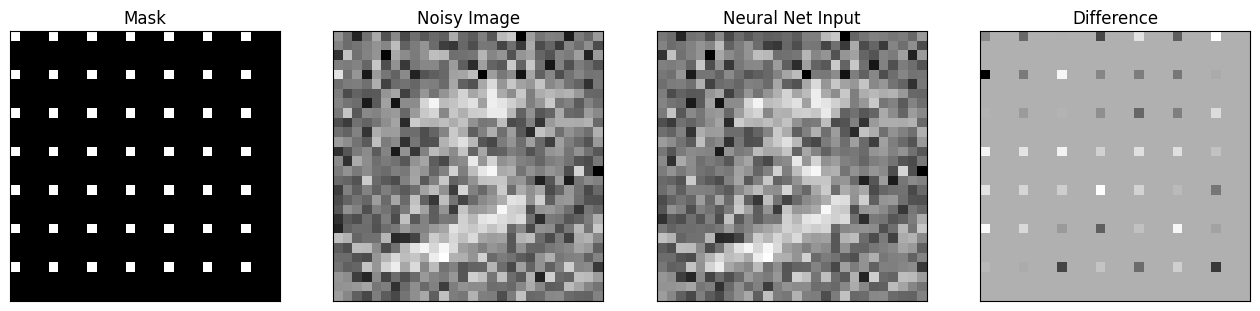

In [ ]:
# Define the masker object
masker = Masker(width = 4, mode='interpolate')

# Show an example of what a mask looks like
net_input, mask = masker.mask(noisy.unsqueeze(0), 0)
plot_tensors([mask, noisy[0], net_input[0], net_input[0] - noisy[0]],
            ["Mask", "Noisy Image", "Neural Net Input", "Difference"])

## Popular models for denoising tasks <a class="anchor" id="model"></a>

Two popular models are the DnCNN and the Unet

TODO? put more info here

In [ ]:
class DnCNN(nn.Module):
    def __init__(self, channels=1, num_of_layers=20):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        features = 64
        layers = []
        layers.append(nn.Conv2d(in_channels=channels, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(num_of_layers - 2):
            layers.append(nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(features))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=features, out_channels=channels, kernel_size=kernel_size, padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        out = self.dncnn(x)
        return out

In [ ]:
#TODO babynet

In [ ]:
model = DnCNN(num_of_layers=5)  # We only use 5 layers, to speed up training
print(model)

DnCNN(
  (dncnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
)


## Training the model! <a class="anchor" id="training"></a>

In [ ]:
loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [ ]:
data_loader = DataLoader(noisy_mnist_train, batch_size=32, shuffle=True)

for i, batch in enumerate(data_loader):
    noisy_images, clean_images = batch

    net_input, mask = masker.mask(noisy_images, i)
    net_output = model(net_input)

    loss = loss_function(net_output*mask, noisy_images*mask)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if i % 10 == 0:
        print("Loss (", i, "): \t", round(loss.item(), 4))

    if i == 100:
        break

Loss ( 0 ): 	 0.0205
Loss ( 10 ): 	 0.0126
Loss ( 20 ): 	 0.0117
Loss ( 30 ): 	 0.0126
Loss ( 40 ): 	 0.0108
Loss ( 50 ): 	 0.0109
Loss ( 60 ): 	 0.0111
Loss ( 70 ): 	 0.011
Loss ( 80 ): 	 0.0108
Loss ( 90 ): 	 0.0116
Loss ( 100 ): 	 0.0116


In [ ]:
test_data_loader = DataLoader(noisy_mnist_test,
                                              batch_size=32,
                                              shuffle=False,
                                              num_workers=3)
i, test_batch = next(enumerate(test_data_loader))
noisy, clean = test_batch

With our trained model, we have a choice. We may do a full
-invariant reconstruction, or we may just run the noisy data through the network unaltered.

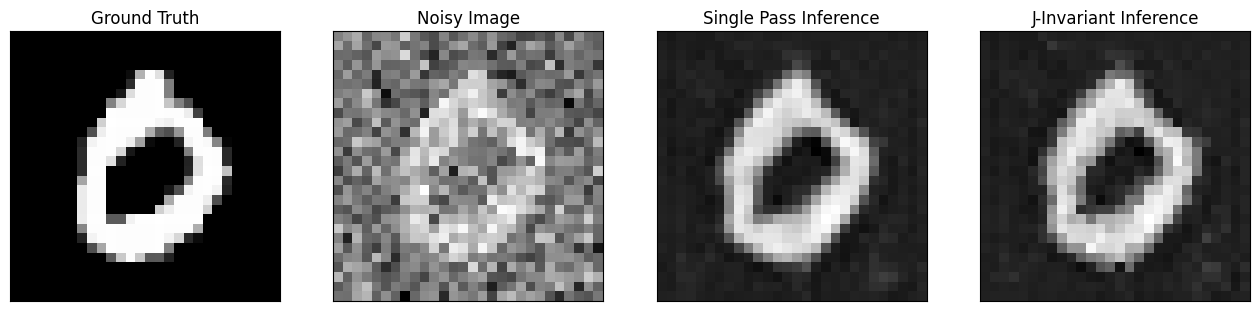

In [ ]:
simple_output = model(noisy)
invariant_output = masker.infer_full_image(noisy, model)

idx = 3
plot_tensors([clean[idx], noisy[idx], simple_output[idx], invariant_output[idx]],
            ["Ground Truth", "Noisy Image", "Single Pass Inference", "J-Invariant Inference"])

In [ ]:
print("Test loss, single pass: ", round(loss_function(clean, simple_output).item(), 3))
print("Test loss, J-invariant: ", round(loss_function(clean, invariant_output).item(), 3))

Test loss, single pass:  0.017
Test loss, J-invariant:  0.021


While both the simple and invariant output are significantly denoised, the invariant output has a mild pixelation.

This is due to the fact that neighboring pixels are denoised using different information, leading to discontinuities in the reconstructed output.